# Thinning MCMC outputs

This notebook illustrates how to use `pbnn.utils.misc.thinning_fn` for thinning a MCMC output.

In [1]:
import blackjax
import flax.linen as nn
import jax
import jax.numpy as jnp
import jax.random as jr
import jax.scipy.stats as stats
import matplotlib.pyplot as plt
import numpy as np
from jax.flatten_util import ravel_pytree
from matplotlib.gridspec import GridSpec

from pbnn.mcmc.langevin import sgld
from pbnn.utils.analytical_functions import gramacy_function
from pbnn.utils.plot import plot_on_axis
from pbnn.utils.misc import thinning_fn

%load_ext watermark

### Generate data

In [2]:
n = 100
noise_level = 0.1

np.random.seed(0)
X = 20 * np.random.rand(n, 1)
X_test = np.linspace(0, 20, 200)[:, None]
X, X_test = jnp.array(X), jnp.array(X_test)

noise, noise_test = (
    np.random.randn(n, 1) * noise_level,
    np.random.randn(len(X_test), 1) * noise_level,
)

y = gramacy_function(X, noise)
y_test = gramacy_function(X_test, noise_test)

An NVIDIA GPU may be present on this machine, but a CUDA-enabled jaxlib is not installed. Falling back to cpu.


### Define the network, loglikelihood and logprior 

In [3]:
# define loglikelihood et logprior
class network(nn.Module):
    """Simple MLP."""

    @nn.compact
    def __call__(self, x):
        x = nn.Dense(
            features=50,
            kernel_init=nn.initializers.normal(),
            bias_init=nn.initializers.normal(),
        )(x)
        x = nn.tanh(x)
        x = nn.Dense(
            features=50,
            kernel_init=nn.initializers.normal(),
            bias_init=nn.initializers.normal(),
        )(x)
        x = nn.tanh(x)
        x = nn.Dense(
            features=1,
            kernel_init=nn.initializers.normal(),
            bias_init=nn.initializers.normal(),
        )(x)
        return x


def loglikelihood_fn(parameters, data, sig_noise: float = noise_level):
    """Gaussian log-likelihood"""
    X, y = data
    return -jnp.sum(
        0.5 * (y - network().apply({"params": parameters}, X)) ** 2 / sig_noise**2
    )


def logprior_fn(parameters):
    """Compute the value of the log-prior density function."""
    flat_params, _ = ravel_pytree(parameters)
    return jnp.sum(stats.norm.logpdf(flat_params))

### Run the SGLD algorithm

In [4]:
# set some hyperparameters
step_size = 1e-6
num_iterations = 100_000
burnin = 80_000
batch_size = 32

# generate initial positions
rng_key = jr.PRNGKey(0)
keys = jr.split(rng_key)

init_positions = network().init(keys[0], X)["params"]

# run SGLD
positions, ravel_fn, predict_fn = sgld(
    X=X,
    y=y,
    loglikelihood_fn=loglikelihood_fn,
    logprior_fn=logprior_fn,
    init_positions=init_positions,
    batch_size=batch_size,
    step_size=step_size,
    num_iterations=num_iterations,
    rng_key=keys[1]
)

# remove burnin
positions = jax.tree_util.tree_map(lambda xx: xx[burnin:], positions)

### Thinning

The MCMC output is thinned by minimizing the energy distance using the function `thinning_fn`. Here, we thin the MCMC output of size 20000 into a subsample of size 2000.

In [5]:
# thin the MCMC output
rpositions = ravel_fn(positions)
idx = thinning_fn(rpositions, size=2000)

# filter with the indices
positions = jax.tree_util.tree_map(lambda xx: xx[idx], positions)

# predict
f_predictions = predict_fn(network, positions, X_test).squeeze()

# generate the noisy predictions
_, key = jr.split(keys[1])
y_predictions = f_predictions + noise_level * jr.normal(
    key, shape=(len(f_predictions), 1)
)

### Plot the prediction intervals

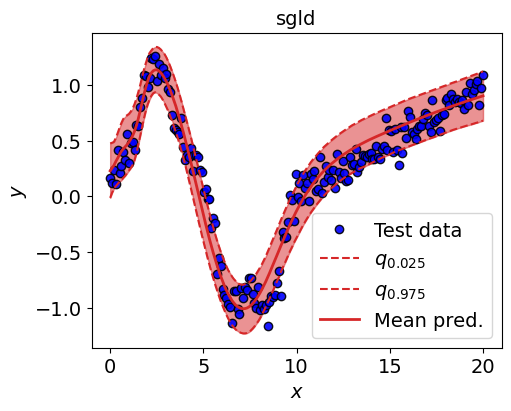

In [6]:
fig = plt.figure(constrained_layout=True, figsize=(5, 4))
gs = GridSpec(nrows=1, ncols=1, figure=fig)
alpha = 0.05

mean_prediction = jnp.median(y_predictions, axis=0)
qlow = jnp.quantile(y_predictions, 0.5 * alpha, axis=0)
qhigh = jnp.quantile(y_predictions, (1 - 0.5 * alpha), axis=0)

ax = fig.add_subplot(gs[0])
plot_on_axis(ax, X_test, y_test, mean_prediction, qlow, qhigh, title=f"sgld")

In [7]:
%reload_ext watermark
%watermark -n -u -v -iv -w -a 'Brian Staber'

Author: Brian Staber

Last updated: Tue Feb 27 2024

Python implementation: CPython
Python version       : 3.11.7
IPython version      : 8.21.0

blackjax  : 1.1.0
jax       : 0.4.23
matplotlib: 3.8.2
flax      : 0.8.0
numpy     : 1.26.3

Watermark: 2.4.3

